# Text Generation using Recurrent Neural Network

### Content
- [1. Mounting the google drive to google colab](#1.-Mounting-the-google-drive-to-google-colab)
- [2. Standard Imports for Recurrent Neural Networks](#2.-Standard-Imports-for-Recurrent-Neural-Networks)
- [3. Loading the txt file that is used for RNN](#3.-Loading-the-txt-file-that-is-used-for-RNN)
- [4. Exploring text dataset](#4.-Exploring-text-dataset)
- [5. Numerical encode the sentences and features](#5.-Numerical-encode-the-sentences-and-features)
- [6. train-test-split X and y](#6.-train-test-split-X-and-y)
- [7. Create RNN model](#7.-Create-RNN-model)
- [8. Creating ModelCheckpoint and callback requirements](#8.-Creating-ModelCheckpoint-and-callback-requirements)
- [9.Training my RNN model](#9.Training-my-RNN-model)
- [10. evaluating performance of model](#10.-evaluating-performance-of-model)
  - [10.1 Training Accuracy & Loss](#10.1-Training-Accuracy-&-Loss)
  - [10.2 Testing Accuracy & Loss](#10.2-Testing-Accuracy-&-Loss)
  - [10.3 Plotting train and test together](#10.3-Plotting-train-and-test-together)
- [11. Loading my pre-trained weights to resume training](#11.-Loading-my-pre-trained-weights-to-resume-training)
- [12.Try generating text using help from keras.io](#12.Try-generating-text-using-help-from-keras.io)
- [13. Try correct spelling of generating text using TextBlob](#13.-Try-correct-spelling-of-generating-text-using-TextBlob)
- [14. Evaluation with other model runs & Conclusion](#14.-Evalulation-with-other-model-runs-&-Conclusion)

### 1.  Mounting the google drive to google colab

In [1]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [3]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation, Bidirectional
# LSTM, GRU
from keras.layers import LSTM, GRU
# plot model architecture
#from .keras.utils import plot_model

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback, EarlyStopping

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used for RNN

- rating 5.0 `reviews` for 'Python for Everybody' course from Coursera is converted to text format
- it is preprocessed to remove url links, emoji. alphabets, spacing and necessary punctuations remains.

In [4]:
# cd to pull my txt file from my google drive into google colab
#%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep punctuations this time
data = re.sub("[^a-zA-Z.,?!'\";:-]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

### 4. Exploring text dataset

- there are a total of 36 characters which includes spacing, alphabets and necessary punctuations
- these unique characters are mapped to numerical values & vice-versa.
- the numerical values are then mapped into np.zeros array for feeding into the RNN model
- the output will be predicted np.zeros array which will be mapped back to numerical values and back to characters

In [5]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  36


In [6]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 ':': 7,
 ';': 8,
 '?': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [7]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: '!',
 2: '"',
 3: "'",
 4: ',',
 5: '-',
 6: '.',
 7: ':',
 8: ';',
 9: '?',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'j',
 20: 'k',
 21: 'l',
 22: 'm',
 23: 'n',
 24: 'o',
 25: 'p',
 26: 'q',
 27: 'r',
 28: 's',
 29: 't',
 30: 'u',
 31: 'v',
 32: 'w',
 33: 'x',
 34: 'y',
 35: 'z'}

### 5. Numerical encode the sentences and features

- the numerical mapping will be encoded using np.zeros
- maxlen=100, means the text input into the RNN model will be 100 characters long

In [8]:
len(data)

1208987

In [9]:
text = data

In [10]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 402963


In [11]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming. attentive save the ', 't auditing this course helped me a lot in learning this language programming. attentive save the mon', 'uditing this course helped me a lot in learning this language programming. attentive save the money ', 'ting this course helped me a lot in learning this language programming. attentive save the money i w', 'g this course helped me a lot in learning this language programming. attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [12]:
len(text)

1208987

In [13]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

### 6. train-test-split X and y

X and y are split into train and test sets, **shuffle=False** is used as reviews are written in a sequence

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 7. Create RNN model

model is created as a function for saving checkpoints in the future referenced from [source](https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6)
- model is instantiated with: 
  - Sequential(), 
  - then added in a LSTM layer batches of 128, input shape=(100, 36)
  - then added a Dense layer with 36 characters which the RNN is trying to predict
  - then a final Activation 'softmax' as the is a multi-class classification/prediction
  
- model is compiled with:
  - loss = 'categorical_crossentropy' as it is multi-class classification
  - optimizer='adam' which is standard
  - metrics=['accuracy'] for classification

In [16]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(Bidirectional(LSTM(128), input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [17]:
model_ckpt.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               168960    
_________________________________________________________________
dense (Dense)                (None, 36)                9252      
_________________________________________________________________
activation (Activation)      (None, 36)                0         
Total params: 178,212
Trainable params: 178,212
Non-trainable params: 0
_________________________________________________________________


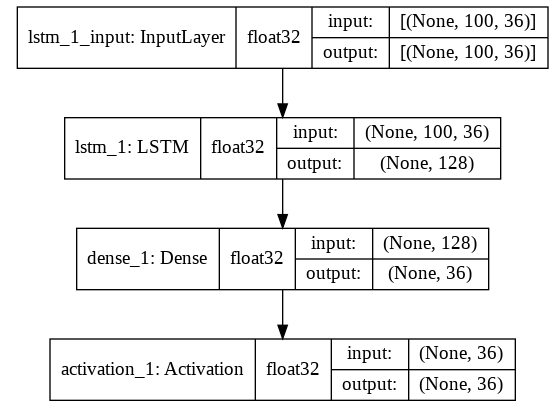

In [ ]:
from IPython.display import Image
Image(filename='model topology.png')

### 8. Creating my ModelCheckpoint and callback requirements

- checkpoint path to save weights and best model if disconnection occurs while fitting

In [18]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

- ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
    [source](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

In [19]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [20]:
es = EarlyStopping(monitor='val_loss', patience=10)

- adjust the temperature parameter to generate more or less random predictions when trying to generate text[source](https://www.tensorflow.org/tutorials/text/text_generation)
- when temperature =1, means the samples produced will be more diverse


In [21]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

- the function generates text after each epoch, so we can monitor the progress of the model by the semantics of the text generated

In [22]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [23]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr, es]

### 9.Training my RNN model

- model is trained for 100 epoch

In [24]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=100, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/100
2362/2362 [==============================] - 157s 53ms/step - loss: 2.4123 - accuracy: 0.3209 - val_loss: 1.6215 - val_accuracy: 0.5411

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "d i had a great experience its fun learning this course and its a new way i had learned its a better"
d i had a great experience its fun learning this course and its a new way i had learned its a better and the course was the course and the course and the course and course and in the course and the programming and the course and the was a programming all wer and the course and and the programming and the and the course and the course and the course and the course and experine so me the course and in python and the course and in the course and in the course is a programming and is and the courser
----- diversity: 0.5
----- Generating with seed: "d i had a great experience its fun learning this course and its a new way i had learned its a better"
d i had a

### 10. evaluating performance of model

#### 10.1 Training Accuracy & Loss

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [26]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

9445/9445 - 154s - loss: 0.8011 - accuracy: 0.7574


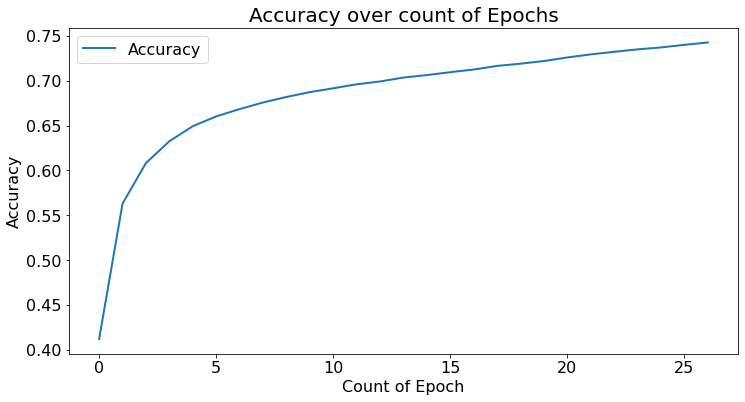

In [27]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


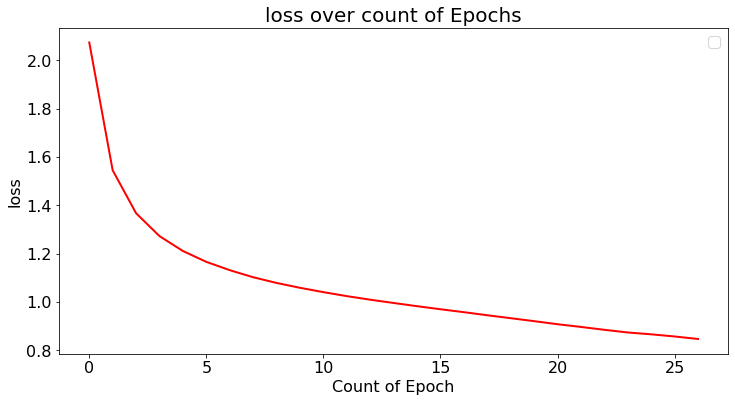

In [28]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

#### 10.2 Testing Accuracy & Loss

In [29]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

3149/3149 - 51s - loss: 1.0930 - accuracy: 0.6895


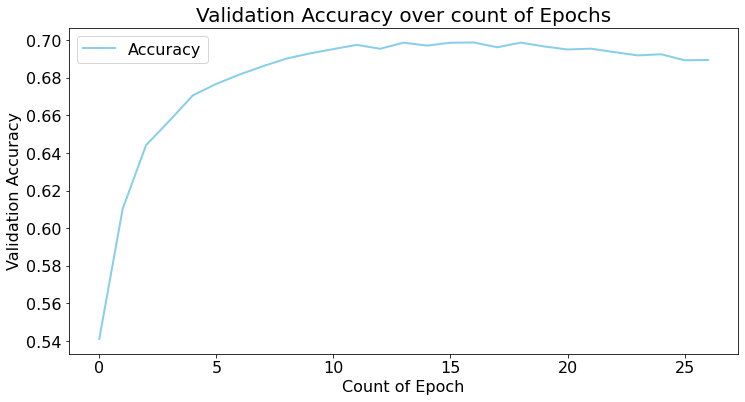

In [30]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=2, color='skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

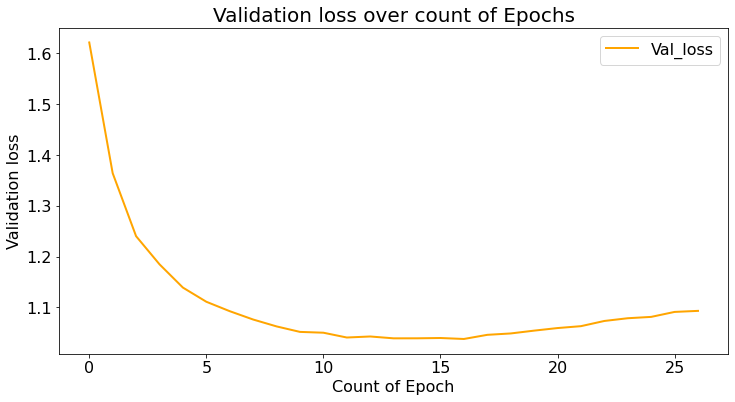

In [31]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=2, label='Val_loss', color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

#### 10.3 Plotting train and test together

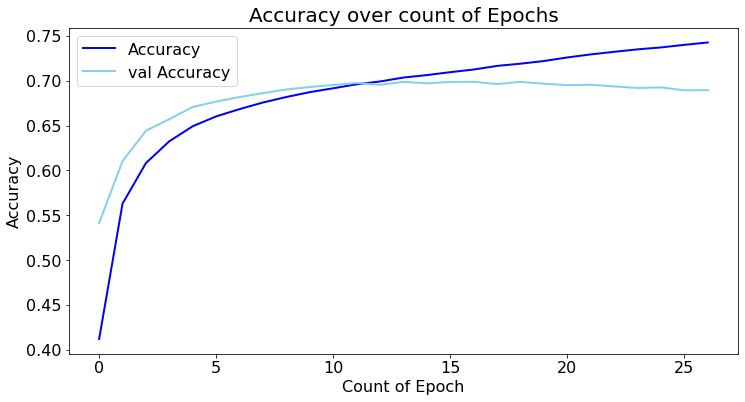

In [32]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=2, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


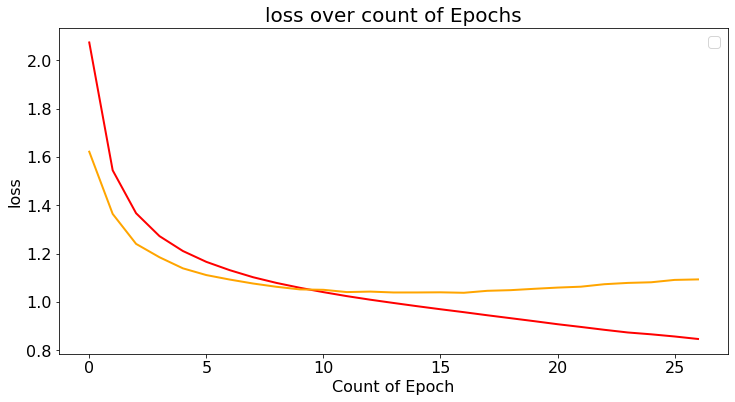

In [33]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 11. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=5, validation_data =(X_test, y_test),callbacks=callbacks))

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 12.Try generating text using help from keras.io

- testing the trained model to generate text given a random index/integer
- which the integer will be mapped into the 36 different characters
- diversity in this case refers to temperature too:
  - lower the diversity/temperature, makes the model generate text that are more conservative
  - higher the diveristy/temperature, makess the model generate text that have more diversity but might be prone to mistakes

In [34]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [35]:
print(generate_text(500, 0.2))

l definitely recommend this course to other people and will continue using coursera as a learning to learn python in this specialization. i will recommend this course to anyone who wants to start learning python and programming from the course in the course. the course is really good at a little bit of the best of the course and the course is a great job of python programming language and enjoyed this course and the assignments are such a course to be a programming language to the best introduction to the best courses and the best course is make the course i have ever mentoos well. i would did


In [36]:
print(generate_text(500, 0.5))

ry easy to understand, dr.chuck will repeat the important concepts patiently and carefully. i recommend this course to anyone who wants to learn python on python programming language. i also not support.thank you so much and approach to teach starting for beginner with python and has done while like me and the way that i found this course to good and those who have no programming lint thinking of the course i have ever cample language in great to the next courses and the awasime experience with no programming language such a great introduction to python and interesting and even more courses an


In [37]:
print(generate_text(500, 1))

s been    years since i lost touch with programming. i was afraid i would never be able to face the cost of the basics of python good read that it cores on python courses i hol i haven't get   degret knowledge for making time, highly recommend!" "i am really awesome. the instructor  so that, dr. chuck say the rusting material ladies for those who does highly get started rights, experience istro programmers to gever humai-am.  an ifforum tot in week. i wanting to the better. out they. i will recommend this lose mo.it amazing experience wor the my here." "this is an excellent course, you making 


In [38]:
print(generate_text(1000, 0.2))

ent. actually it is excellent period. i almost did not take another online class because the ibm data students with lots of course to anyone who have no programming background. i have to make the course and i think it also interesting and the course was a great course. " "this is a great course for beginners. i liked the course in the python courses i have ever encouraging through the course.  this course is a great course for beginners. i am a great course for beginners. this is a great course for those who does a great course! " "i have to take this course and the assignments are also very desiged to start programming in a the book is the first course i have ever seen well as it was really a great teacher i have a bit of experience and the best professor assignments are solut of the course in the first programming course.  the course is very clear and the examples and continue with programming with the concept of python programming language and the instructor is very good at explaini

In [39]:
print(generate_text(1000, 0.5))

start a journey over python then i'll recommend him her to kindly pursue this course at least as a so easy to understand and a great introduction to programming content is the best course for beginners. the course can be take python. i will learn the basics of python. the instructor is great!" "this is a great start for someone who is interested in journey with this course and it's easy to understand through this course and the teaching severence with the requrers and the course was a great experience in coursera courses for those who already that easily. " "this is a great job in the one off coursera is the next courses and i am really great for someone who the course from scratch in the assignments as well. thank you dr. chuck to anyone who is interesting course for a programming courses, this is a great course for beginners. i have to the a more code if you never feel how to thank you see in my concise and complete some of the python language but never course for beginners. it was a

In [40]:
print(generate_text(1000, 1))

eat experience to code a little programs by myself. i completely sure that i'll go to the next classes to ortilianal " "this was me. good its challenged so makes  infercliably banzion. and kuy a bitweer base s.good basic and thring more and getting another from me to none of the simplicity were a real for programming background.he material scredble done to take thrics in cructarer's. if you are all the course what'he the informative and programming in solit' style in coursera." "this is an excitede' programming in this for the suthers. " in this course with about the course in spicianize your is really great teacher. and many comprimensing, and how to do this course, i have learnt every class courses   " "hand structure , dafating. i really loved the soled and actually cleared to wait the best in startuge so unature. give in you'll, learning from beginners.ly too just not having lost first hand with the certifes of the course aspes lessons and makes it enjoyh leable. mont. this course 

In [41]:
print(generate_text(2000, 1))

teresting and easy at the same time. thank you that was so great and i've learned many things in this python, because it will dee while programming deaid ti."gengral. to program highly to comprehend the current of such prof. charles severance is extremely any programming secies. at  "ind your person and doing the lecturer" is a very good courses are very useful courses for me. "if-learning.     years and to the ming a spyend!" "   i down through. taxk "this course too xample and grasp using  jo a programming and thankyout looks and much me about python, this is really lidest of coding courses on videos of programing for everybody-'s end using programing. thank you!  "course was gleat all the video. the course contructor, a good jobber, but now, dr chuck is textbook it short cantit.thank you so mucal course as list of the online before. i thorued. great course watching their command on any on-sometsing take the courses and even a programming in my cole. highly recommend this teacherally

### 13. Try correct spelling of generating text using TextBlob

In [42]:
generated1 = generate_text(1000, 1)

In [43]:
from textblob import TextBlob

In [44]:
b = TextBlob(generated1)
b.correct()

TextBlob("an my journey into programming. " thank you for this course - it was just what i was looking for!great course, but left us follow, that right screpof and i liked everything through this course and explains jobs in on what great manor, each science for this picksul to the weeks for getting starting. with given a lit course been males! note before, i have an only the tutoring specific learn getting for me to takes person, both charles severance content all the end only kinder ton this is the best pit a will continue now. thank drisssord severance!" "this course is approach but well was why quite you will learning experience with the person to programming to down to understand patron. it's so easy to funny time, and also course into set of while to have some semaisching.the possible allows every bit of computer language raising and quite best good .i hope to expect to using." "this course skill of no programming knowledge of course programming skill understand why works it is a 

In [45]:
generated2 = generate_text(2000, 1)

b2 = TextBlob(generated2)
b2.correct()

TextBlob("so knows what errors they are likely to make and what questions they are likely to ask and addresses them help me more courses .. dont after through. very useful. so i could take more confivelo, and continual courses!" "this is truth of many at be are respond, assignment were looking to learn patron. " "this course  it was awesome knowledge for the beginning as i amazing introduction for the course from extremity and get the pace lit.  like me to learn basic and help at my concise and learn at  and if an claret you reads motivataning. the instructor enslyshily might by the textbook, programming really in a read like so that my interesting and important tools like see your farrand concept. i know what and the first online course. "i want to learn patron, its an incredion fun other. i have       passion forward enjoying teaching is very this course to anyone who has not carttely new to programming students of information time of the first course courses.this open knowndowledge 